In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from string import punctuation

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.linear_model import LinearRegression

reg = LinearRegression()

sid = SentimentIntensityAnalyzer()
stop_words = stopwords.words('English')

pd.set_option('display.max_colwidth', -1)

<ipython-input-1-cc92c9a22e1a>:20: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
def clean_text(s):
    if s[-1] == '.': 
        s = s[:-1]
    return s.lower().replace('\n', ' ')

# Data Preprocessing

Before starting our analyses, we load the data into a pandas dataframe.

We then remove certain allegation data that are related to findings or conclusions, before cleaning up the texts and removing duplicate entries

In [3]:
headers = ["Allegation ID", "Section Name", "Column Name", "Text Content", "Area Name", "Median Income", "Complainant Gender", "Complainant Race", "Complainant Birth Year"]

raw_data = pd.read_csv('./data/community_allegation_narratives.csv', 
    names=headers
)

# Removing lines without meaningful summaries
data = raw_data[~raw_data['Text Content'].isin([
    '(None Entered)',
    'NOMISCONDUCT\n(NOTIF)',
    'NOT SUSTAINED'
])]
data['Text Content'] = data['Text Content'].apply(lambda x: clean_text(x))
data = data.drop_duplicates(subset=['Text Content'])

<ipython-input-3-6ed7420e8e0f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Text Content'] = data['Text Content'].apply(lambda x: clean_text(x))


In [4]:
data.columns

Index(['Allegation ID', 'Section Name', 'Column Name', 'Text Content',
       'Area Name', 'Median Income', 'Complainant Gender', 'Complainant Race',
       'Complainant Birth Year'],
      dtype='object')

After all is said and done, this is the format of our data. Note that we still have organization variables such as allegation ID, and that median income is still a string.

In [6]:
data

,Allegation ID,Section Name,Column Name,Text Content,Area Name,Median Income,Complainant Gender,Complainant Race,Complainant Birth Year
0,1062924,Accused Members,Initial / Intake Allegation,the complainant stated that she was involved in traffic accident with another ewvillan the complainant alleged that the accused officer incorrectly and inacurrately completed the traffic crash accident report the complainant did not have her case report number,Hermosa,"$39,057",F,Hispanic,1971.0
1,1050875,Accused Members,Initial / Intake Allegation,"the complainant alleges that the accused failed to arrest a female offender who threw a bottle at her and refused to leave the premises, the complainant alleges that the accused failed to arrest a female offender who threw a bottle at her and refused to leave the premises",Chicago Lawn,"$32,944",F,Black,1977.0
3,1060347,Accused Members,Initial / Intake Allegation,"and that she was afraid that the might come back. the reporting alleges that the accused was rude and and stated in an aggressive ""maybe we can look at the tape. if so scared, change your locks. i'm not to do anything for you.”",North Park,"$51,589",F,White,1970.0
4,1060347,Accused Members,Initial / Intake Allegation,"the reporting party alleges that she called to speak to the accused, who is assigned to investigate her case. the reporting party alleges that she stated to the accused that the offender had all of her information and keys to her place of residence and that she was afraid that the offender might come back. the reporting party alleges that the accused was rude and unprofessional and stated in an aggressive manner, ""maybe we can look at the tape. if you're so scared, change your locks. i'm not going to do anything for you.”",North Park,"$51,589",F,White,1970.0
5,1049777,Accused Members,Initial / Intake Allegation,the reporting party alleges that the accused officer had his vehicle illegally towed due to loud music. the reporting party alleges that the speakers in his vehicle are not operating therefore; the impounding of his vehicle was just harassment from the accused officer,Chicago Lawn,"$32,944",M,Black,1989.0
...,...,...,...,...,...,...,...,...,...
47699,1063984,Accused Members,Initial / Intake Allegation,"the complainant alleged that the accused officer refused to properly investigate the victim's report of a “road rage"" altercation with another driver",North Park,"$51,589",M,Hispanic,1988.0
47704,1049236,Accused Members,Initial / Intake Allegation,"the reporting party, who is representing himself, alleges that the accused struck him with a squad car, which caused serveral bruises on his face, legs, knees and back. the reporting party further alleges that while he was on the ground, the accused stepped on his back, handcuffed him and then threw him in the backseat of the squad car",Greater Grand Crossing,"$26,354",M,Black,1980.0
47708,1051081,Accused Members,Initial / Intake Allegation,"the reporting party alleges that the accused officer was rude and unprofessional in that the accused officer called the victim to clear a missing person and the victim stated that he would have to wait until he was available to serve him. the accused officer responded, ""l don't want to hear that shit you fucking jag off.""",Douglas,"$29,099",M,Black,1964.0
47710,1051081,Current Allegations,Allegation,"the complainant, police officer gregory rudolph #16639, unit 184 alleges that on 03 january 2012 at 2255 hours, via the telephone detective joseph mc guire #20016, unit 620 was rude and unprofessional the complainant, police officer gregory rudolph #16639, unit 184 further alleegs that on 04 january 2012 at 1745 hours, via the telephone detective joseph mc guire #20016, unit 620 threatened him and denied his request to speak to a supervisor",Douglas,"$29,099",M,Black,1964.0


# Introduction

For our analyses, we will be examining the relationship of sentiment to certain geographic and complainant features, such as median income, complainant race, and complainant race and gender.

We will then attempt to corroborate or reject our results by using linear regression to learn a model on the data using almost every feature.

Finally, we will examine the differences between the race and race/gender analyses, and whether either of them significantly correlate to the sentiment calculated for each allegation.

# Income

In [7]:
# Find all compound sentiment scores, divided by area
area_scores = {}
for n, (area, text, income) in enumerate(zip(data['Area Name'], data['Text Content'], data['Median Income'])):
    clean = clean_text(text)
    
    if area not in area_scores:
        area_scores[area] = {
            'total_score': 0,
            'count': 0,
            'income': income
        }
    
    scores = sid.polarity_scores(clean)
    
    area_scores[area]['count'] += 1
    area_scores[area]['total_score'] += scores['compound']

In [8]:
sorted_scores = sorted([
    (
        area, 
        area_scores[area]['total_score'] / area_scores[area]['count'],
        area_scores[area]['income']
    )
    for area in area_scores
], key=lambda line: line[1])

In [9]:
pd.DataFrame(sorted_scores, columns=['Area', 'Score', 'Income'], )

,Area,Score,Income
0,Edison Park,-0.599305,"$84,331"
1,Jefferson Park,-0.597945,"$60,384"
2,Lincoln Square,-0.589593,"$62,427"
3,South Lawndale,-0.573953,"$30,603"
4,Hegewisch,-0.565878,"$50,252"
...,...,...,...
72,O'Hare,-0.420273,"$46,065"
73,Oakland,-0.407486,"$28,269"
74,Portage Park,-0.395742,"$56,649"
75,Edgewater,-0.394468,"$46,103"


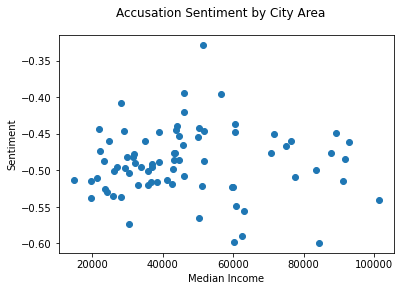

In [10]:
plot_x = [int(x[2][1:].replace(',', '')) for x in sorted_scores]
plot_y = [y[1] for y in sorted_scores]

plt.suptitle('Accusation Sentiment by City Area')
plt.xlabel('Median Income')
plt.ylabel('Sentiment')
plt.scatter(plot_x, plot_y)

# Race

In [11]:
race_scores = {}
for race, text in zip(data['Complainant Race'], data['Text Content']):
    clean = clean_text(text)
    if race == 'Native American/Alaskan Native':
        # Not enough examples to confidently include
        continue
    elif race == 'Asian/Pacific Islander':
        race = 'Asian'
    
    if race not in race_scores:
        race_scores[race] = {
            'total_score': 0,
            'count': 0
        }
    
    scores = sid.polarity_scores(clean)
    
    race_scores[race]['count'] += 1
    race_scores[race]['total_score'] += scores['compound']

In [12]:
race_data = dict(sorted([
    (race, -1 * race_scores[race]['total_score'] / race_scores[race]['count'])
    for race in race_scores if type(race) == str
], key=lambda item: item[1]))

<BarContainer object of 4 artists>

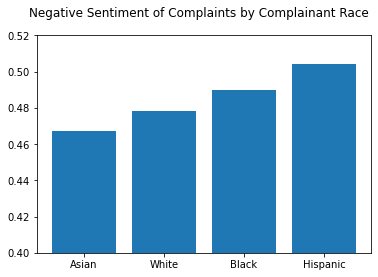

In [13]:
plt.suptitle('Negative Sentiment of Complaints by Complainant Race')
plt.ylim([0.4, 0.52])
plt.bar(race_data.keys(), [race_data[race] for race in race_data])

In [14]:
pd.DataFrame(race_data.items(), columns=['Race', 'Avg Score'])

,Race,Avg Score
0,Asian,0.467126
1,White,0.478442
2,Black,0.489578
3,Hispanic,0.503951


# Race and Gender

In [15]:
race_gender_scores = {}
for race, gender, text in zip(data['Complainant Race'], data['Complainant Gender'], data['Text Content']):
    clean = clean_text(text)
    if race == 'Native American/Alaskan Native':
        # Not enough examples to confidently include
        continue
    elif race == 'Asian/Pacific Islander':
        race = 'Asian'
    elif float in [type(race), type(gender)]:
        continue
        
    key = race + '_' + gender
    
    if key not in race_gender_scores:
        race_gender_scores[key] = {
            'total_score': 0,
            'count': 0
        }
    
    scores = sid.polarity_scores(clean)
    
    race_gender_scores[key]['count'] += 1
    race_gender_scores[key]['total_score'] += scores['compound']

In [16]:
race_gender_data = dict(sorted([
    (key, -1 * race_gender_scores[key]['total_score'] / race_gender_scores[key]['count'])
    for key in race_gender_scores if type(key) == str
], key=lambda item: item[1]))

<BarContainer object of 8 artists>

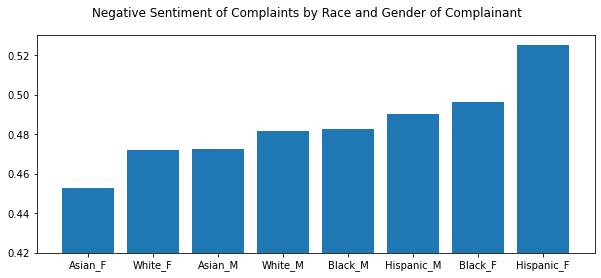

In [17]:
plt.figure(figsize=(10, 4))
plt.suptitle('Negative Sentiment of Complaints by Race and Gender of Complainant')
plt.ylim([0.42, 0.53])
plt.bar(race_gender_data.keys(), [race_gender_data[key] for key in race_gender_data])

In [18]:
pd.DataFrame(race_gender_data.items(), columns=['Race', 'Avg Score'])

,Race,Avg Score
0,Asian_F,0.453001
1,White_F,0.472198
2,Asian_M,0.472570
3,White_M,0.481604
4,Black_M,0.482587
5,Hispanic_M,0.490032
6,Black_F,0.496370
7,Hispanic_F,0.524962


# Linear Regression

To perform regression, first we will limit the number of unique categorical values in our data, so that we have a reasonable number of features when we later perform one-hot encoding. We start with limiting ourselves to the top ten most frequently occurring areas.

In [19]:
frequent_areas = data['Area Name'].value_counts()[:10].index.tolist()

frequent_areas

['Austin',
 'Auburn Gresham',
 'Loop',
 'Near North Side',
 'North Lawndale',
 'West Englewood',
 'South Shore',
 'Near West Side',
 'Woodlawn',
 'Humboldt Park']

In [20]:
out = data['Area Name'].isin(frequent_areas)

filtered_df = data[out]

filtered_df['Median Income'] = filtered_df['Median Income'].map(lambda x: float(re.sub("[^0-9]", "", x)))

filtered_df

<ipython-input-20-1fe1062a7d55>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Median Income'] = filtered_df['Median Income'].map(lambda x: float(re.sub("[^0-9]", "", x)))


,Allegation ID,Section Name,Column Name,Text Content,Area Name,Median Income,Complainant Gender,Complainant Race,Complainant Birth Year
6,1075895,Accused Members,Initial / Intake Allegation,"the complainant alleged that the accused officer falsely issued parking tickets to her and her friend, the complainant stated that they were issued tickets for not having parking permits when both vehicles had the permits displayed",Near West Side,71663.0,F,Asian/Pacific Islander,1993.0
21,1067568,Accused Members,Initial / Intake Allegation,the reporting party alleged that the accused officers falsely arrested him for three bags of heroin. it is further alleged that the accused officers searched and impounded his vehicle without justification,Austin,31478.0,M,Black,1988.0
23,1067568,Current Allegations,Allegation,"the reporting party alleged that on 11 february 2014, at 1100 hours, at 5 unknown officers in civilian attire, in unmarked squad cars falsely arrested him and searched and impounded his vehicle without justification. the reporting party alleged that on 11 february 2014, at 1100 hours, at 5 unknown officers in civilian attire, in unmarked squad cars falsely arrested him and searched and impounded his vehicle without justification. the reporting party alleged that on 11 february 2014, at 1100 hours, at ___ 5 unknown officers in civilian attire, in unmarked squad cars falsely arrested him and searched and impounded his vehicle without justification. the reporting party alleged that on 11 february 2014, at 1100 hours, at 5 unknown officers in civilian attire, in unmarked squad cars falsely arrested him and searched and impounded his vehicle without justification the reporting party alleged that on 11 february 2014, at 1100 hours, at 5 unknown officers in civilian attire, in unmarked squad cars falsely arrested him and searched and impounded his vehicle without justification",Austin,31478.0,M,Black,1988.0
32,1069205,Accused Members,Initial / Intake Allegation,the reporting party alleged that the accused officers are following her and allowing crime to occur,Loop,91851.0,NaN,NaN,NaN
44,1067675,Accused Members,Initial / Intake Allegation,threatened to shoot people without justification,Loop,91851.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
47675,1063398,Accused Members,Initial / Intake Allegation,the complainant alleges that the accused officer searched him inappropriately,North Lawndale,22132.0,M,Black,1977.0
47677,1063398,Current Allegations,Allegation,"reynaldo sei documented u time as inmate alleges that on 30 january 2013, 1050 hours, at rrat! hed him inappropriately. note, this is is now serving chicago police department officer",North Lawndale,22132.0,M,Black,1977.0
47693,1057069,Accused Members,Initial / Intake Allegation,"the complainant alleges that the accused officer issued him six citations without justification. the complainant alleges that the accused officer searched his establishment without justification. the complainant alleges that the accused officers searched his establishment without justification. the complainant alleges that the accused officer informed him that he was responding to a call of patrons in the street which the victim stated was incorrect. the complainant alleges that the accused officer threatened to lock the victim and his patrons up. the complainant alleges that the accused threatened to beat their ""ass"" and shut his establishment down",Austin,31478.0,M,Black,1958.0
47695,1057069,Current Allegations,Allegation,ails) victim/offender situation armed? weapon types,Austin,31478.0,M,Black,1958.0


In [21]:
# headers = ["Allegation ID", "Section Name", "Column Name", "Text Content", "Area Name", "Median Income", "Complainant Gender", "Complainant Race", "Complainant Birth Year"]

X = filtered_df.drop(columns=["Allegation ID", "Section Name", "Column Name", "Text Content"]) # These don't tell us much about the nature of the complaint, but are mostly used to organize data

X = pd.get_dummies(X, columns=["Area Name", "Complainant Gender", "Complainant Race"]) # These are the categorical variables that we need to one-hot encode for regression. Change this if you have a better implementation

features = X.columns

X = np.nan_to_num(X.to_numpy())

print(X[:10])

print(features)

[[7.1663e+04 1.9930e+03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00]
 [3.1478e+04 1.9880e+03 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00]
 [3.1478e+04 1.9880e+03 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00]
 [9.1851e+04 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00]
 [9.1851e+04 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0

In [22]:
y = list(filtered_df['Text Content'])
y = np.asarray([sid.polarity_scores(txt)['compound'] for txt in y])

In [23]:
y[:10] # sample of negative sentiments.

array([-0.1027, -0.7906, -0.4588, -0.4588, -0.6597, -0.765 ,  0.    ,
        0.34  , -0.875 , -0.6597])

In [24]:
print(y.shape)
print(X.shape)

(7477,)
(7477, 19)


In [25]:
y_train = y[:5600]
y_test = y[5600:]

X_train = X[:5600]
X_test = X[5600:]

In [26]:
reg.fit(X_train,y_train)

LinearRegression()

These were the final coefficients we achieved for each feature.

In [27]:
pd.DataFrame([round(c, 4) for c in reg.coef_], index = features)

,0
Median Income,0.0000
Complainant Birth Year,0.0000
Area Name_Auburn Gresham,-0.0052
Area Name_Austin,-0.0015
Area Name_Humboldt Park,0.0008
Area Name_Loop,-0.0027
Area Name_Near North Side,-0.0139
Area Name_Near West Side,0.0249
Area Name_North Lawndale,0.0357
Area Name_South Shore,-0.0510


# Significance of Difference in Sentiments

In [28]:
from scipy.stats import ttest_ind

In [29]:
cat = filtered_df.drop(columns=["Allegation ID", "Section Name", "Column Name", "Text Content"])
cat = np.nan_to_num(cat.to_numpy())

y = list(filtered_df['Text Content'])
y = np.asarray([sid.polarity_scores(txt)['compound'] for txt in y])

In [30]:
sent_F = y[np.where(cat[:,2]=='F')]
sent_M = y[np.where(cat[:,2]=='M')]

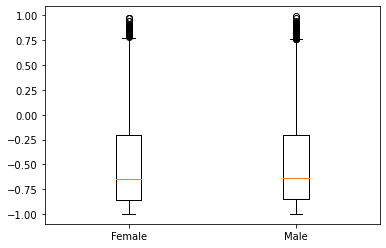

In [31]:
plt.boxplot([sent_F, sent_M], labels=['Female', 'Male'])
plt.show()

In [32]:
# P value between male and female complaint sentiments
ttest_ind(sent_F, sent_M)

Ttest_indResult(statistic=-0.7373886557814943, pvalue=0.4609098035963891)

In [33]:
sent_black = y[np.where(cat[:,3]=='Black')]
sent_white = y[np.where(cat[:,3]=='White')]
sent_hispanic = y[np.where(cat[:,3]=='Hispanic')]
sent_asian = y[np.where(cat[:,3]=='Asian/Pacific Islander')]

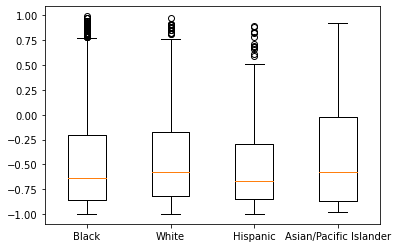

In [34]:
plt.boxplot([sent_black, sent_white, sent_hispanic, sent_asian], labels=['Black', 'White', 'Hispanic', 'Asian/Pacific Islander'])
plt.show()

In [35]:
# P value between male and female complaint sentiments
p_vals = np.zeros((4,4))
sents = [sent_black, sent_white, sent_hispanic, sent_asian]
for i in range(4):
    for j in range(4):
        p_vals[i][j] = ttest_ind(sents[i], sents[j])[1]

print(p_vals)

[[1.         0.06829741 0.18195407 0.05356938]
 [0.06829741 1.         0.02275279 0.16218192]
 [0.18195407 0.02275279 1.         0.01958343]
 [0.05356938 0.16218192 0.01958343 1.        ]]


In [36]:
race_sents = {}
for race, text in zip(data['Complainant Race'], data['Text Content']):
    clean = clean_text(text)
    if race == 'Native American/Alaskan Native':
        # Not enough examples to confidently include
        continue
    elif race == 'Asian/Pacific Islander':
        race = 'Asian'
    
    if race not in race_sents:
        race_sents[race] = []
    
    scores = sid.polarity_scores(clean)
    
    race_sents[race].append(scores['compound'])

In [37]:
np.average(race_sents['Black'])

-0.48957798930144747